### Contents
1. Perceptrons
2. Digit recognition using Tensorflow
3. **Digit recognition using Pytorch**

### Aim
At the end of this session, you will be able to:
- understand perceptrons in the context of logistic regression
- understand feed-forward ANNs
- feel the differences of the two most famous DL frameworks

### Install and import dependencies

In [3]:
!pip install torch

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

### Load relevant data

Like in the Keras\Tensorflow notebook, we'll be using MNIST, a dataset of 28x28 grayscale images of hand-written digits.

In [40]:
# When we load the images, they will be in Image objects
# We want to convert them to PyTorch tensors, which are similar to NumPy arrays
transform = transforms.ToTensor()

BATCH_SIZE = 4
# When we load the datasets for the first time, we download them from the internet
# In later instances, we can access the downloaded files locally
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
# The DataLoader defines the mini-batch size (which is often confusingly called batch_size)
# and whether to shuffle our dataset when splitting into batches.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
# TODO: Make a testloader that doesn't shuffle the data
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# Our classes are just the digits from 0 to 9
classes = np.arange(10)

In [37]:
# We can get some random training images this way
dataiter = iter(trainloader)
images, labels = dataiter.next()

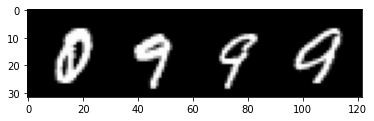

    0     9     9     9


In [26]:
# Helper function to show an image
def imshow(img):
    npimg = img.numpy()
    # The make_grid PyTorch function returns tensor with re-ordered
    # dimensions, so we need to manually fix that.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# PyTorch has a lot of utilities for visualisations and pre-processing
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define the model

If we run our data through only the PyTorch functions (ones in the `nn` and `F` modules below), the framework can automatically calculate gradients for us. Our job here is just to define the number of layers and number of hidden units per layer. We have to make sure that our final number of units matches the number of classes (10 for the case of MNIST).

In [20]:
import torch.nn as nn
import torch.nn.functional as F

# We want a network with 2 hidden layers of 64 and 32 units respectively
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # The nn.Linear function defines a fully-connected (affine) layer
        self.fc1 = nn.Linear(28 * 28, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        # We want to treat our image as a flattened array of 784 pixels, so we reshape it
        x = x.view(-1, 28 * 28)
        # We apply the ReLU non-linearity for each hidden layer
        x = F.relu(self.fc1(x))
        # TODO: What should this be?
        x = F.relu(self.fc2(x))
        # We don't use a ReLU for the final layer
        x = self.fc3(x)
        return x


net = Net()

### Optimise the weights

Once we've defined our model, we need to choose the appropraite loss and optimiser. For classification, we most often use the `CrossEntropyLoss`. You can play around with the optimizer and see what its effect is on the performance of the model, but your default choice will usually be stochastic gradient descent (SGD).

In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# The learning rate (lr) was discussed in the pre-recorded lectures.
# TODO: Make the lr 0.0000001 and 10.0 and re-run the below. What happens? Can you think of why that happens?
optimizer = optim.SGD(net.parameters(), lr=0.01)

# We call one run over the entire dataset an epoch. More complex models require more epochs to train,
# but for this example 2 epochs should be sufficient.
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    # Each epoch runs over the entire dataset. PyTorch prefers to do this with iterators
    for i, data in enumerate(trainloader, 0):
        # data will be a list of batch_size pairs of images and labels
        inputs, labels = data

        # *Important*: We have to manually set the parameter gradients to zero ourselves
        # Missing this is one of the most common mistakes when using PyTorch
        optimizer.zero_grad()

        # We get predictions with the network by calling it this way
        # outputs will be B vectors of 10 numbers called logits
        outputs = net(inputs)
        
        # The loss function takes the logits and converts them to probabilities.
        # It then compares those probabilities to the one-hot encoded versions of the labels
        # E.g. 7 is converted to [0 0 0 0 0 0 0 1 0 0]
        loss = criterion(outputs, labels)
        
        # This function computes the gradients for the current batch
        loss.backward()
        
        # The optimiser then uses the gradients to change the parameters with the equation discussed
        # in the live lecture.
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 0.048
[1,  4000] loss: 0.050
[1,  6000] loss: 0.058
[1,  8000] loss: 0.057
[1, 10000] loss: 0.057
[1, 12000] loss: 0.054
[1, 14000] loss: 0.061
[2,  2000] loss: 0.041
[2,  4000] loss: 0.045
[2,  6000] loss: 0.047
[2,  8000] loss: 0.044
[2, 10000] loss: 0.054
[2, 12000] loss: 0.054
[2, 14000] loss: 0.046
Finished Training


### Save and load the model

PyTorch allows us to save and load the model just by specifying the place we want the model to live. It takes a couple of lines to do either operation.

In [32]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [33]:
loaded_net = Net()
# TODO: What should the argument be?
loaded_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Test using the trained model

Once we have trained our model or loaded a pre-trained one, prediction looks exactly like it did during training

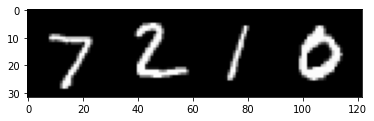

GroundTruth:      7     2     1     0
Predicted:      7     2     1     0


In [43]:
# TODO: Load the first 4 images from the test set (check you understand why we don't get random images here)
dataiter = iter(testloader)
images, labels = dataiter.next()

# Print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Get the logits of our network
# The no_grad function tells PyTorch not to compute gradients in the scope, which
# can save a lot of memory and computation. Whenever you're testing you should use this.
with torch.no_grad():
    outputs = loaded_net(images)

# Each prediction is 10 logits, so we take the index for which the logits is highest
# Warning: torch.max returns both the max and the argmax! We want the argmax, so we take
# the second object returned
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Finally, we want to compute some statistics over the entire testset.

In [45]:
correct = 0
total = 0
# We first compute the overall accuracy
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # TODO: Get logits from our network
        outputs = loaded_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# TODO: Compute the accuracy per class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = loaded_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(BATCH_SIZE):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 97 %
Accuracy of     0 : 98 %
Accuracy of     1 : 98 %
Accuracy of     2 : 95 %
Accuracy of     3 : 97 %
Accuracy of     4 : 97 %
Accuracy of     5 : 97 %
Accuracy of     6 : 98 %
Accuracy of     7 : 94 %
Accuracy of     8 : 95 %
Accuracy of     9 : 96 %


### Optional: How to train on GPU using PyTorch

Assuming that we are on a machine with CUDA capabilities (this can be sometimes difficult to set up on your own machine, but some uni servers have them), the below code should print a CUDA device

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Making PyTorch run on the GPU is then as easy as calling the below functions before doing any computation on them.

In [47]:
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)